In [2]:
##################################################
## Author: Sai Akhil Suggu
## Credits: CSE250A, fall 2019, Prof. Lawrence Saul
## Version: 1.0.1
## Mmaintainer: Sai Akhil Suggu
## Email: saiakhil0034@eng.ucsd.edu
## Status: Done
##################################################

In [218]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

## 1.9 (a) 

Download the file hw1 word counts 05.txt that appears with the homework assignment. 

The file contains a list of 5-letter words (including names and proper nouns) and their counts from a large corpus of Wall Street Journal articles (roughly three million sentences). 

From the counts in this file compute the prior probability P(w) = COUNT(w)/􏰆w′ COUNT(w′). As a sanity check, print out the fifteen most frequent 5-letter words, as well as the fourteen least frequent 5-letter words. Do your results make sense_

In [303]:
data_path = "./data/hw1_word_counts_05_cse250a_fall_2019.txt" # file path in homework folder
data = pd.read_csv(data_path, sep = " ", header = None)
print(data.shape)

(6535, 2)


In [304]:
data.columns = ["word", "word_count"]
data.head(5)

,word,word_count
0,AARON,413
1,ABABA,199
2,ABACK,64
3,ABATE,69
4,ABBAS,290


In [305]:
print(f'number of nans in give data : {data["word_count"].isna().sum()}')

number of nans in give data : 0


Thus, we can go ahead without working on imputation/filling missed values

In [306]:
# making sure all letters are upper case two avoid confusion with uppper and lower case words
data["word"] = data["word"].str.upper()

In [307]:
print(f'number of unique words : {data["word"].nunique()}, number of words : {data.shape[0]}')

number of unique words : 6535, number of words : 6535


Observe that, number of unique words and number of words are same, hence we dont need to do any aggregation, we proceed forward

In [308]:
data["word_count"].describe()

count      6535.000000
mean       1172.893191
std        7707.131636
min           6.000000
25%          24.000000
50%          61.000000
75%         256.000000
max      273077.000000
Name: word_count, dtype: float64

Note that, word cound minimum value is 6, thus, we are considering only values 

In [309]:
# Calculating prior probability
data["prior_probability"] = data["word_count"]/float(data["word_count"].sum())
data.head(5)

,word,word_count,prior_probability
0,AARON,413,0.000054
1,ABABA,199,0.000026
2,ABACK,64,0.000008
3,ABATE,69,0.000009
4,ABBAS,290,0.000038


In [310]:
# Sanity checks to see if the data makes sense
sorted_data = data.sort_values(by = ["word_count"], ascending=False)
sorted_data.head(15)

,word,word_count,prior_probability
5821,THREE,273077,0.035627
5102,SEVEN,178842,0.023333
1684,EIGHT,165764,0.021626
6403,WOULD,159875,0.020858
18,ABOUT,157448,0.020542
5804,THEIR,145434,0.018974
6320,WHICH,142146,0.018545
73,AFTER,110102,0.014365
1975,FIRST,109957,0.014346
1947,FIFTY,106869,0.013943


Observe that, most frquent 5 letter words in Wall Street journal are numbers and prepostions which makes sense

In [311]:
sorted_data.tail(15)

,word,word_count,prior_probability
4622,RALEY,8,1.043725e-06
5093,SERNA,7,9.132590e-07
5872,TOCOR,7,9.132590e-07
3978,NIAID,7,9.132590e-07
1842,FABRI,7,9.132590e-07
4266,PAXON,7,9.132590e-07
2041,FOAMY,7,9.132590e-07
6443,YALOM,7,9.132590e-07
977,CCAIR,7,9.132590e-07
1107,CLEFT,7,9.132590e-07


Observe that, least frquent 5 letter words in Wall Street journal are colloquially/formally very sparingly used words. Note that order of words may be different across different runs as they all have same frequence and hence same probabilituy

## 1.9 (b)

Consider the following stages of the game. 

For each of the following, indicate the best next guess— namely, the letter l that is most likely (probable) to be among the missing letters. 

Also report the probability P (Li = l for some i ∈ {1, 2, 3, 4, 5}|E ) for your guess l. Your answers should fill in the last two columns of this table. (Some answers are shown so that you can check your work.)

In [312]:
incorrectly_guessed = ['A', 'E', 'I', 'O', 'S']
correctly_guessed = ['_','U','_','_','_']
word_length = 5

#Fiding best guess for next letter

In [316]:
def get_condition_set(correctly_guessed, incorrectly_guessed =[]):
    letters = [i for i in correctly_guessed if i != '_']
    if letters:
        return incorrectly_guessed + list(set([i for i in correctly_guessed if i != '_']))
    else :
        return incorrectly_guessed
        

# function testing
print(get_condition_set(correctly_guessed,incorrectly_guessed) == ['A', 'E', 'I', 'O', 'S', 'U'])

True


In [317]:
def get_word_pattern(correctly_guessed=['_' for i in range(word_length)]):
    return [i for i in zip(range(word_length), correctly_guessed,) if i[1] != '_']

# function testing
print( get_word_pattern(correctly_guessed) == [(1, 'U')])

True


In [318]:
def get_pattern_check(word, word_pattern):
    for (index,letter) in word_pattern :
        if (word[index] != letter):
            return False
    return True

# function testing
print(get_pattern_check("MUTRK", get_word_pattern(correctly_guessed)) == True)
print(get_pattern_check("MVTRK", get_word_pattern(correctly_guessed)) == False)

True
True


In [325]:
def get_count_list(letter, letter_arr):
    return sum([1 for i in letter_arr if i == letter])
  
# function testing
get_count_list('U',['_','U','_','_','_']) == 1

True

In [348]:
def does_word_satisfy_condition(word, correctly_guessed, incorrectly_guessed =[]):
    word_pattern = get_word_pattern(correctly_guessed)
    
    # checking if word has condition set of letters which are already guessed incorrectly
    for i in incorrectly_guessed:
         if (i in word):
                return False
    
    correctly_guessed_letters = [ j for j in correctly_guessed if j != '_']
    correct_letters_count_arr =list(zip(correctly_guessed_letters,
        [get_count_list(i, correctly_guessed_letters) for i in correctly_guessed_letters]))
    
    if get_pattern_check(word,word_pattern):
        #print(correct_letters_count_arr)
        for (i,j) in correct_letters_count_arr:
            #print(get_count_list(i, word))
            if get_count_list(i, word) != j:
                return False
        return True
            
    else :
        return False
        
    
    
    # onece we know, condition set is not present in word, we will now check if we have same patter or not 
    return  get_pattern_check(word,word_pattern)

# function testing
print(does_word_satisfy_condition("MUTRK",correctly_guessed,incorrectly_guessed) == True)
print(does_word_satisfy_condition("MUTUK",correctly_guessed,incorrectly_guessed) == False)
print(does_word_satisfy_condition("MVTRK",correctly_guessed,incorrectly_guessed) == False)

True
True
True


In [349]:
## Function to get all the required words satifying given condition
def req_set_words(df,
                  correctly_guessed = ["_" for i in range(word_length)],
                  incorrectly_guessed =[]):

    raw_data = copy.deepcopy(df)
    req_data = raw_data[raw_data["word"].map(lambda x :
            does_word_satisfy_condition(x,correctly_guessed,
                                        incorrectly_guessed))].copy()
    return req_data

In [387]:
# For each letter finding how many words contain that letter and
#its probability to be present in word satisfying given condition

def letter_presence_counts(df, remaining_letters):
    raw_data = copy.deepcopy(df)
    for letter in remaining_letters :
        raw_data[letter] = raw_data["word_count"]*raw_data["word"].map(
            lambda x : 1 if (letter in x) else 0)
        
    req_total_word_count = raw_data["word_count"].sum()
    #print(raw_data.head(5))
    
    #print(f'\ntotal number of occurrences words : {req_total_word_count}')
    
    req_data3 = raw_data.copy().iloc[:,3:].sum().reset_index()
    req_data3.columns = ["letter", "count_occurrence"]
    req_data3["letter_probability"] = req_data3["count_occurrence"]/req_total_word_count
    #print("\nletters, number of occurrences and their probabilities :")
    #print(req_data3.sort_values("count_occurrence", ascending = False).head(5))
    
    req_data3.plot.bar(x='letter', y='letter_probability', rot=0, color = 'b', figsize=(10,6))
    plt.show()
    
    return req_data3[['letter','letter_probability']].loc[req_data3["letter_probability"].idxmax()]

correctly_guessed = ['_', 'U', '_', '_', '_']
incorrectly_guessed = ['A', 'E', 'I', 'O', 'S']


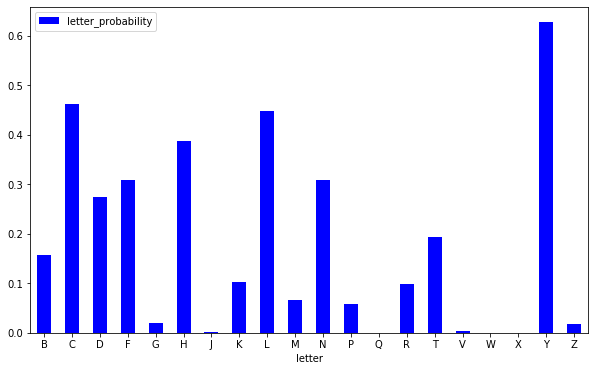

True


In [390]:
def get_best_guess(df,
                   correctly_guessed = ["_" for i in range(word_length)],
                   incorrectly_guessed =[]):
    print(f'correctly_guessed = {correctly_guessed}')
    print(f'incorrectly_guessed = {incorrectly_guessed}')
    raw_data = copy.deepcopy(df)
    req_data = req_set_words(raw_data, correctly_guessed, incorrectly_guessed)
    #print(f"words satisfying given condition : {req_data.shape[0]}")
    #print(f'total number of occurrences words : {req_data["word_count"].sum()}')
    #print(f'\nsample dataframe with words satisfying condition :')
    #print(req_data.head(5))
    
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    condition_set = get_condition_set(correctly_guessed,incorrectly_guessed)
    #print( f'\nletters that need not be used further : {condition_set}')
    remaining_letters = [i for i in alphabet if i not in condition_set]
    #print( f'\nletters that can be used further : {remaining_letters}')
          
    ltr_prob_dict = dict(letter_presence_counts(req_data, remaining_letters))
    ltr_prob_dict["letter_probability"] = round(ltr_prob_dict["letter_probability"], 4)
    
    return ltr_prob_dict

incorrectly_guessed = ['A', 'E', 'I', 'O', 'S']
correctly_guessed = ['_','U','_','_','_']

# function test

print(get_best_guess(data, correctly_guessed, incorrectly_guessed) == {'letter': 'Y', 'letter_probability': 0.6270})

correctly_guessed = ['_', 'U', '_', '_', '_']
incorrectly_guessed = ['A', 'E', 'I', 'O', 'S']


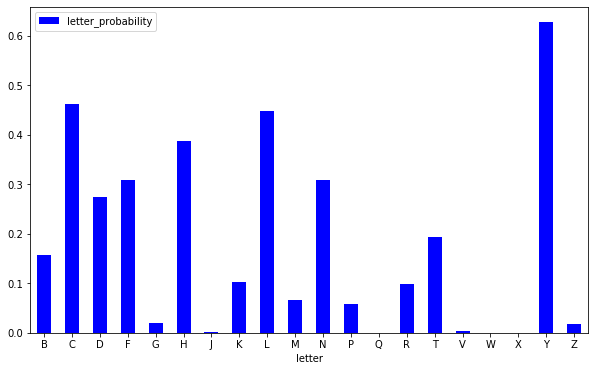

{'letter': 'Y', 'letter_probability': 0.627}

In [392]:
incorrectly_guessed = ['A', 'E', 'I', 'O', 'S']
correctly_guessed = ['_','U','_','_','_']
get_best_guess(data, correctly_guessed, incorrectly_guessed)

In [393]:
correctly_guessed_list = [["_","_","_","_","_"],["_","_","_","_","_"],
                    ["A","_","_","_","S"], ["A","_","_","_","S"],
                    ["_","_","O","_","_"], ["_","_","_","_","_"],
                       ["D","_","_","I","_"], ["D","_","_","I","_"],
                      ["_","U","_","_","_"]]
                       
incorrectly_guessed_list = [[],['E','A'],[],['I'],['A','E','M','N','T'],
                     ['E','O'],[],['A'],['A','E','I','O','S']]

In [394]:
#hw_df = pd.DataFrame({'correctly_guessed' : correctly_guessed_list, 'incorrectly_guessed': incorrectly_guessed_list})

In [395]:
#hw_df[['correctly_guessed','incorrectly_guessed']].apply( 
 #   lambda x :(get_best_guess(data, x[0], x[1])))#

In [396]:
#hw_df

correctly_guessed = ['_', '_', '_', '_', '_']
incorrectly_guessed = []


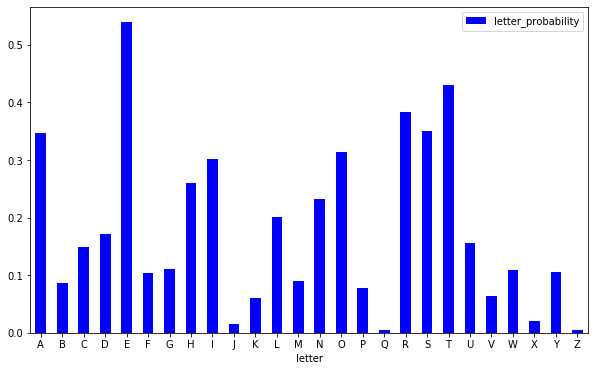

{'letter': 'E', 'letter_probability': 0.5394}



correctly_guessed = ['_', '_', '_', '_', '_']
incorrectly_guessed = ['E', 'A']


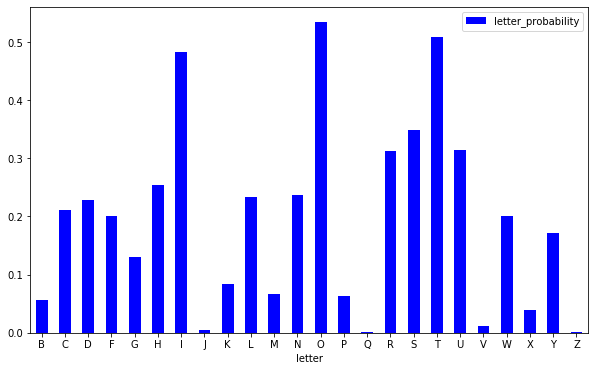

{'letter': 'O', 'letter_probability': 0.534}



correctly_guessed = ['A', '_', '_', '_', 'S']
incorrectly_guessed = []


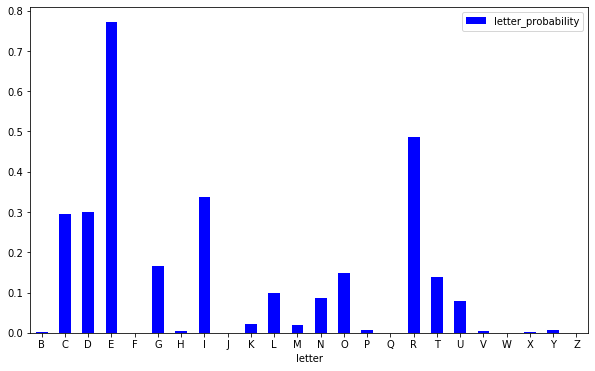

{'letter': 'E', 'letter_probability': 0.7715}



correctly_guessed = ['A', '_', '_', '_', 'S']
incorrectly_guessed = ['I']


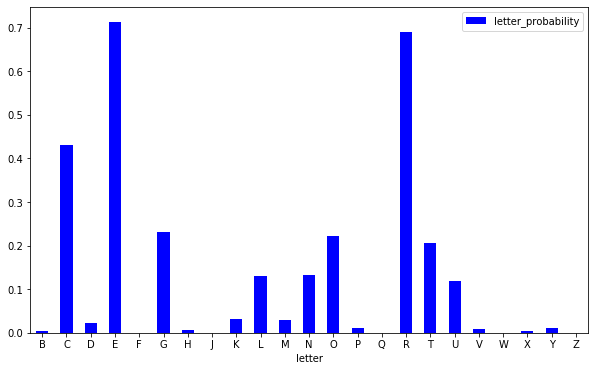

{'letter': 'E', 'letter_probability': 0.7127}



correctly_guessed = ['_', '_', 'O', '_', '_']
incorrectly_guessed = ['A', 'E', 'M', 'N', 'T']


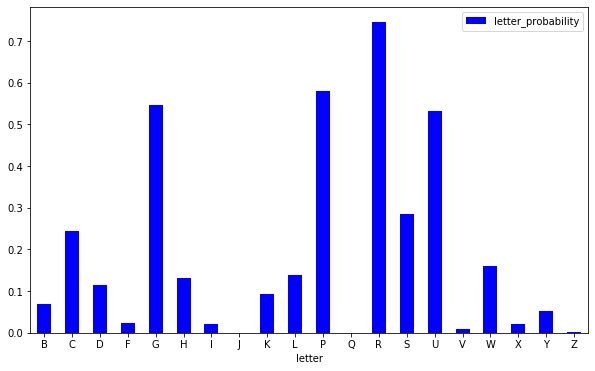

{'letter': 'R', 'letter_probability': 0.7454}



correctly_guessed = ['_', '_', '_', '_', '_']
incorrectly_guessed = ['E', 'O']


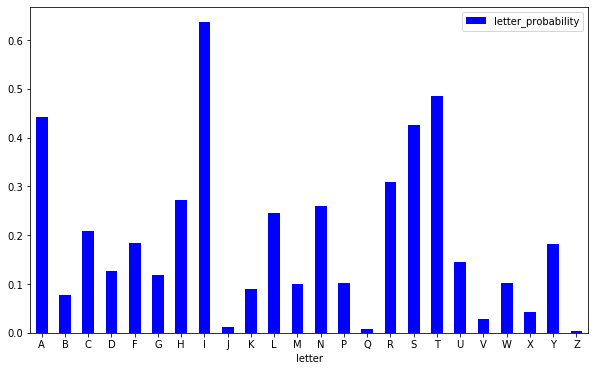

{'letter': 'I', 'letter_probability': 0.6366}



correctly_guessed = ['D', '_', '_', 'I', '_']
incorrectly_guessed = []


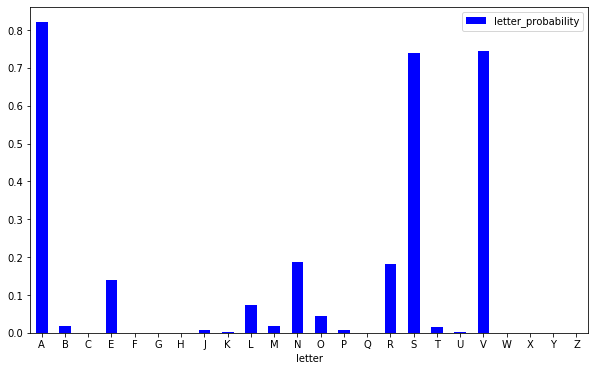

{'letter': 'A', 'letter_probability': 0.8207}



correctly_guessed = ['D', '_', '_', 'I', '_']
incorrectly_guessed = ['A']


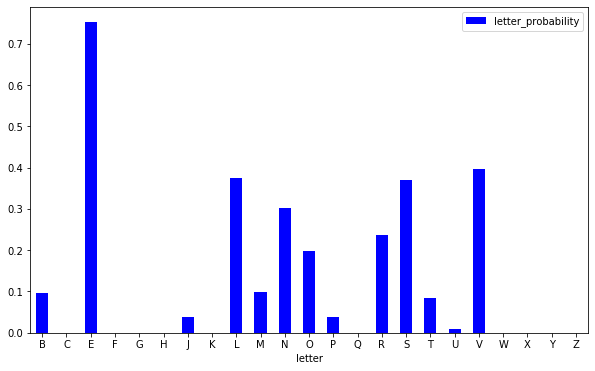

{'letter': 'E', 'letter_probability': 0.7521}



correctly_guessed = ['_', 'U', '_', '_', '_']
incorrectly_guessed = ['A', 'E', 'I', 'O', 'S']


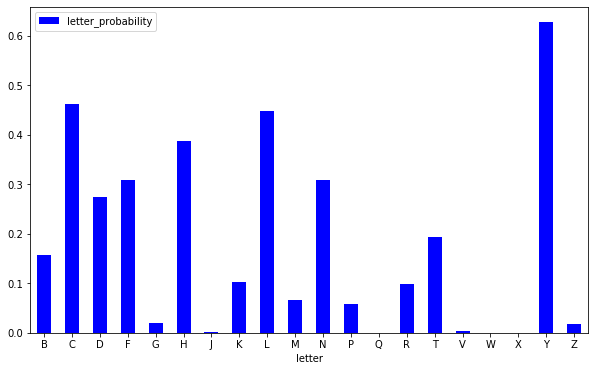

{'letter': 'Y', 'letter_probability': 0.627}





In [399]:
ans_list = []
for W,E in zip(correctly_guessed_list, incorrectly_guessed_list):
    ans = get_best_guess(data, W, E)
    print(ans)
    print('\n\n')
    ans_list.append([W,E, ans])

## Final Answer

In [400]:
ans_list

[[['_', '_', '_', '_', '_'],
  [],
  {'letter': 'E', 'letter_probability': 0.5394}],
 [['_', '_', '_', '_', '_'],
  ['E', 'A'],
  {'letter': 'O', 'letter_probability': 0.534}],
 [['A', '_', '_', '_', 'S'],
  [],
  {'letter': 'E', 'letter_probability': 0.7715}],
 [['A', '_', '_', '_', 'S'],
  ['I'],
  {'letter': 'E', 'letter_probability': 0.7127}],
 [['_', '_', 'O', '_', '_'],
  ['A', 'E', 'M', 'N', 'T'],
  {'letter': 'R', 'letter_probability': 0.7454}],
 [['_', '_', '_', '_', '_'],
  ['E', 'O'],
  {'letter': 'I', 'letter_probability': 0.6366}],
 [['D', '_', '_', 'I', '_'],
  [],
  {'letter': 'A', 'letter_probability': 0.8207}],
 [['D', '_', '_', 'I', '_'],
  ['A'],
  {'letter': 'E', 'letter_probability': 0.7521}],
 [['_', 'U', '_', '_', '_'],
  ['A', 'E', 'I', 'O', 'S'],
  {'letter': 'Y', 'letter_probability': 0.627}]]